Model 1- Averaging Class Probabilities

Caroline Forsythe 
25/06/2024 (last updated 15/07/2024)

This script creates three different machine learning models to predict a patient's status as healthy '0' or disease state (endometriosis) '1', given RNA-sequencing and methylation data. The first logistic regression model uses only the RNA-seq data, the second uses only the methylation data. The third 'meta model' uses the average of probabilities of patient classifications as '1' from each of the previous estimators on new test data. Metrics including confusion matrix and ROC curve visualizations are created for each model.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt

In [2]:
rna_data = pd.read_csv('sig_DEG_counts_37samples.csv', index_col = 0)
meth_data = pd.read_csv('transposedMethylationCounts.csv', index_col = 0)
labels = pd.read_csv('sample_labels.csv', header = None)

# check data
print(rna_data.head())
print(meth_data.head())
print(labels.head())

        ENSG00000040531  ENSG00000066230  ENSG00000077157  ENSG00000092098  \
N_0026              499              653              150              294   
N_0035              172              505              104              214   
N_0036              461              575              182              390   
N_0039              150              519               36              207   
N_0042              614             1359               90              529   

        ENSG00000099901  ENSG00000100242  ENSG00000102904  ENSG00000103260  \
N_0026              209             1028              653               50   
N_0035              198              451              565                7   
N_0036              257              584              685               28   
N_0039              305              716              606               22   
N_0042              349              937              745               38   

        ENSG00000104872  ENSG00000104886  ...  ENSG00000274653

In [3]:
# check indicies 
print(rna_data.index)
print(meth_data.index)

# intersection of indices, patients with both data
common_indices = meth_data.index.intersection(rna_data.index)
print(common_indices)

# reindex methylation data
meth_new = meth_data.loc[common_indices]
print(meth_new.head())

# check that patient datasets now match
(rna_data.index == meth_new.index).all()

Index(['N_0026', 'N_0035', 'N_0036', 'N_0039', 'N_0042', 'N_0045', 'N_0046',
       'N_0054', 'N_0055', 'N_0057', 'N_0058', 'N_0060', 'W_001', 'W_002',
       'W_004', 'W_006', 'W_008', 'W_010', 'W_011', 'W_012', 'W_015', 'W_017',
       'W_018', 'W_023', 'W_028', 'W_030', 'W_033', 'W_035', 'W_037', 'W_039',
       'W_040', 'W_047', 'W_049', 'W_052', 'W_053', 'W_054', 'W_058'],
      dtype='object')
Index(['S_669', 'S_682', 'FT_018', 'LA_064', 'LA_067', 'LA_068', 'LA_076',
       'LA_110', 'N_0012', 'N_0014', 'N_0017', 'N_0026', 'N_0032', 'N_0035',
       'N_0036', 'N_0037', 'N_0039', 'N_0042', 'N_0043', 'N_0045', 'N_0046',
       'N_0054', 'N_0055', 'N_0057', 'N_0058', 'N_0060', 'ST_009', 'ST_112',
       'ST_113', 'ST_189', 'W_001', 'W_002', 'W_003', 'W_004', 'W_005',
       'W_006', 'W_008', 'W_010', 'W_011', 'W_012', 'W_015', 'W_017', 'W_018',
       'W_019', 'W_023', 'W_028', 'W_029', 'W_030', 'W_033', 'W_035', 'W_037',
       'W_039', 'W_040', 'W_042', 'W_044', 'W_046', 'W_047', 

True

In [4]:
# split data for training and validation
X_rna_train, X_rna_val, y_rna_train, y_rna_val = train_test_split(rna_data, labels, test_size = 0.33, random_state = 3)
X_meth_train, X_meth_val, y_meth_train, y_meth_val = train_test_split(meth_new, labels, test_size = 0.33, random_state = 3)

In [5]:
# check that same patients are in both training sets
print((X_rna_train.index == X_meth_train.index).all())
print(X_rna_train.shape[0] == X_meth_train.shape[0])

True
True


In [6]:
# standardize the features for RNA dataset
scaler_rna = StandardScaler()
X_rna_train_scale = scaler_rna.fit_transform(X_rna_train)
X_rna_val_scale = scaler_rna.transform(X_rna_val)

# standardize the features for Methylation dataset
scaler_meth = StandardScaler()
X_meth_train_scale = scaler_meth.fit_transform(X_meth_train)
X_meth_val_scale = scaler_meth.transform(X_meth_val)

# convert the scaled arrays back to DataFrames
X_rna_train_df = pd.DataFrame(X_rna_train_scale)
X_rna_val_df = pd.DataFrame(X_rna_val_scale)
X_meth_train_df = pd.DataFrame(X_meth_train_scale)
X_meth_val_df = pd.DataFrame(X_meth_val_scale)

y_rna_train_df = pd.Series(y_rna_train.values.ravel())
y_meth_train_df = pd.Series(y_meth_train.values.ravel())

In [7]:
# use GridSearchCV with K-Fold cross-validation to find the best parameters
warnings.filterwarnings('ignore')
logreg_rna = LogisticRegression(random_state = 42)

solvers = ['lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [0.01, 0.1, 1, 10, 100]
grid_rna = dict(solver = solvers, penalty = penalty, C = c_values)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_rna = GridSearchCV(estimator = logreg_rna, param_grid = grid_rna, cv = kf, n_jobs = -1, scoring = 'accuracy')
grid_search_rna.fit(X_rna_train_df, y_rna_train_df)
best_model_rna = grid_search_rna.best_estimator_

print("Best: %f using %s" % (grid_search_rna.best_score_, grid_search_rna.best_params_))

Best: 0.790000 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


Validation Accuracy of RNA Model: 0.62


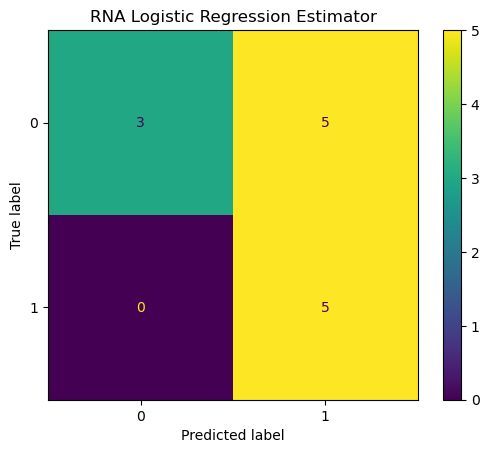

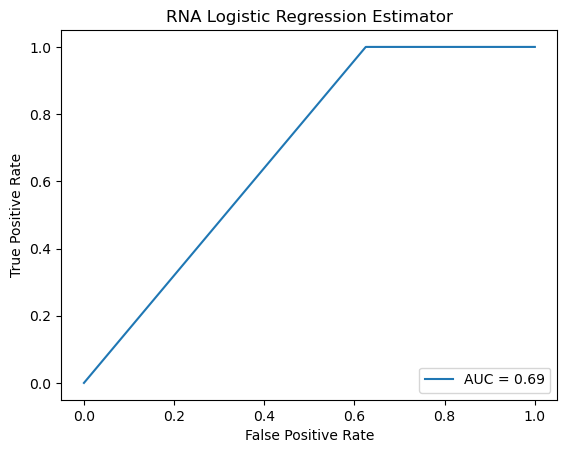

In [8]:
# make prediction on validation dataframe and determine accuracy
rna_predict = best_model_rna.predict(X_rna_val_df)
accuracy = accuracy_score(y_rna_val, rna_predict)
print(f'Validation Accuracy of RNA Model: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_rna_val, rna_predict, labels = best_model_rna.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = best_model_rna.classes_)
disp.plot()
plt.title('RNA Logistic Regression Estimator')  
plt.show()

# calculate tp, tn, fp, and fn, for later metrics 
tn_rna, fp_rna, fn_rna, tp_rna = confusion_matrix(y_rna_val, rna_predict).ravel()

# ROC curve
fpr_rna, tpr_rna, thresholds_rna = roc_curve(y_rna_val, rna_predict, pos_label = 1)
roc_auc_rna = auc(fpr_rna, tpr_rna)
display = RocCurveDisplay(fpr = fpr_rna, tpr = tpr_rna, roc_auc = roc_auc_rna)
display.plot()
plt.title('RNA Logistic Regression Estimator')  
plt.show()

# calculate other metrics 
rna_test_accuracy= round(accuracy_score(y_rna_val, rna_predict), 2)
rna_specifity= round(tn_rna /(tn_rna + fp_rna), 2)
rna_recall= round(tp_rna /(tp_rna + fn_rna), 2)
rna_precision= round(tp_rna /(tp_rna + fp_rna), 2)
rna_f1score= round(2*((rna_precision * rna_recall)/(rna_precision + rna_recall)), 2)
rna_auc = round(auc(fpr_rna, tpr_rna), 2) 
rna_list= ["RNA logistic regression", rna_test_accuracy, rna_specifity, rna_recall, rna_precision, rna_f1score, rna_auc]

In [9]:
# rna beta values
beta_rna = best_model_rna.coef_[0]
features_rna = X_rna_train.columns
beta_dict_rna = dict(zip(features_rna, beta_rna))
sorted_dict_rna = sorted(beta_dict_rna.items(), key=lambda item: abs(item[1]), reverse = True)
print("Beta values (coefficients) for RNA model:")
for feature, beta in sorted_dict_rna:
    print(f"{feature}: {beta}")

Beta values (coefficients) for RNA model:
ENSG00000210127: 0.038310544081871706
ENSG00000231240: 0.03827492025552113
ENSG00000256001: 0.03611562521470918
ENSG00000197191: -0.03343921113620077
ENSG00000279716: -0.03298667726067927
ENSG00000184343: -0.032469164856651814
ENSG00000126461: -0.03212116001242691
ENSG00000167244: -0.030554515900497993
ENSG00000229372: -0.02999340362820521
ENSG00000137171: -0.028324917066127536
ENSG00000264701: -0.02805758329348485
ENSG00000210140: 0.02753328639663387
ENSG00000185504: -0.02725569370939015
ENSG00000238164: -0.027122555915198555
ENSG00000249491: -0.02668652485728866
ENSG00000268047: -0.02646522872713541
ENSG00000214353: -0.025626504917815644
ENSG00000103260: -0.025554486738226474
ENSG00000185803: -0.025178222581333485
ENSG00000197768: -0.02398386511155802
ENSG00000234409: -0.023872485012490303
ENSG00000274653: -0.023729997765365763
ENSG00000092098: -0.02341278249123695
ENSG00000224729: -0.022976804027741948
ENSG00000135454: -0.022701160162027605


In [10]:
# use GridSearchCV with K-Fold cross-validation to find the best parameters
warnings.filterwarnings('ignore')
logreg_meth = LogisticRegression(random_state = 42)

solvers = ['lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [0.01, 0.1, 1, 10, 100]
grid_meth = dict(solver = solvers, penalty = penalty, C = c_values)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_meth = GridSearchCV(estimator = logreg_meth, param_grid = grid_meth, cv = kf, n_jobs = -1, scoring = 'accuracy')
grid_search_meth.fit(X_meth_train_df, y_meth_train_df)
best_model_meth = grid_search_meth.best_estimator_

print("Best: %f using %s" % (grid_search_meth.best_score_, grid_search_meth.best_params_))

Best: 0.820000 using {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


Validation Accuracy of Methylation Model: 0.77


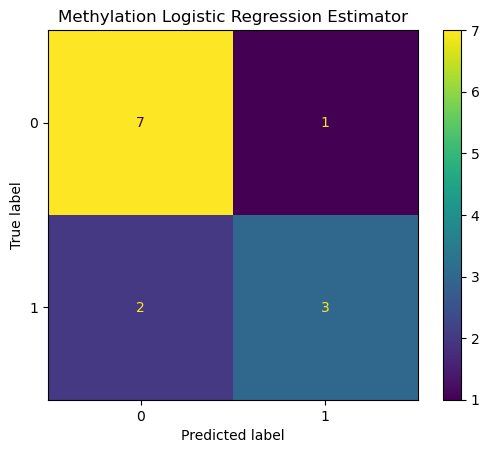

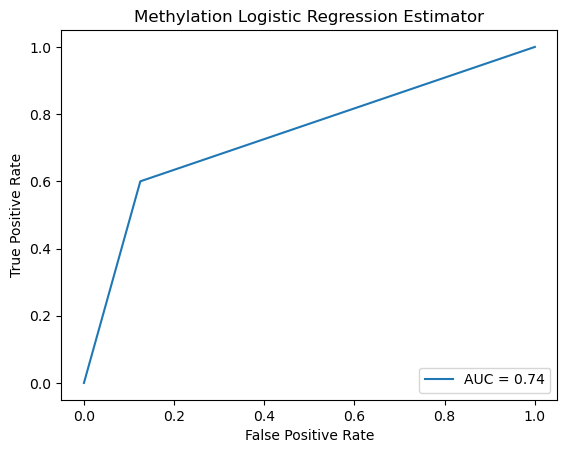

In [11]:
# make prediction on validation dataframe and determine accuracy
meth_predict = best_model_meth.predict(X_meth_val_df)
accuracy = accuracy_score(y_meth_val, meth_predict)
print(f'Validation Accuracy of Methylation Model: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_meth_val, meth_predict, labels = best_model_meth.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = best_model_meth.classes_)
disp.plot()
plt.title('Methylation Logistic Regression Estimator')  
plt.show()

# calculate tp, tn, fp, and fn, for later metrics 
tn_meth, fp_meth, fn_meth, tp_meth = confusion_matrix(y_meth_val, meth_predict).ravel()

# ROC curve
fpr_meth, tpr_meth, thresholds_meth = roc_curve(y_meth_val, meth_predict, pos_label = 1)
roc_auc_meth = auc(fpr_meth, tpr_meth)
display = RocCurveDisplay(fpr = fpr_meth, tpr = tpr_meth, roc_auc = roc_auc_meth)
display.plot()
plt.title('Methylation Logistic Regression Estimator')  
plt.show()

# calculate other metrics 
meth_test_accuracy= round(accuracy_score(y_meth_val, meth_predict), 2)
meth_specifity= round(tn_meth /(tn_meth + fp_meth), 2)
meth_recall= round(tp_meth /(tp_meth + fn_meth), 2)
meth_precision= round(tp_meth /(tp_meth + fp_meth), 2)
meth_f1score= round(2*((meth_precision * meth_recall) / (meth_precision + meth_recall)), 2)
meth_auc = round(auc(fpr_meth, tpr_meth), 2) 
meth_list= ["Methylation logistic regression", meth_test_accuracy, meth_specifity, meth_recall, meth_precision, meth_f1score, meth_auc]

In [12]:
# meth beta values
beta_meth = best_model_meth.coef_[0]
features_meth = X_meth_train.columns
beta_dict_meth = dict(zip(features_meth, beta_meth))
sorted_dict_meth = sorted(beta_dict_meth.items(), key=lambda item: abs(item[1]), reverse = True)
print("Beta values (coefficients) for Methylation model:")
for feature, beta in sorted_dict_meth:
    print(f"{feature}: {beta}")


Beta values (coefficients) for Methylation model:
ENSG00000216548: 0.9113159321985588
ENSG00000184661: 0.7951041512776995
ENSG00000289901: -0.6061328827930199
ENSG00000234067: 0.5744076318123705
ENSG00000289708: -0.5688177762327953
ENSG00000240160: -0.5326106855141165
ENSG00000226243: -0.46369086874273596
ENSG00000222636: 0.45471535430040383
ENSG00000276040: 0.38151557613659765
ENSG00000244130: 0.36019799425411
ENSG00000100083: 0.3361565073662166
ENSG00000241241: 0.2991845990275293
ENSG00000286919: -0.2646837264763786
ENSG00000292423: -0.2644641946950297
ENSG00000141198: -0.23738182583224424
ENSG00000237381: 0.2162988931022083
ENSG00000250397: -0.13973236932382554
ENSG00000170540: 0.13752553159580858
ENSG00000130731: 0.12981502875793938
ENSG00000227535: 0.12118380125251252
ENSG00000275969: 0.09999152593931321
ENSG00000127578: 0.0804311391716
ENSG00000168453: -0.0766252047141809
ENSG00000227120: -0.05597351517505188
ENSG00000224127: -0.04634486709341916
ENSG00000197562: -0.0364601530770

In [13]:
# train base classifiers on entire training set
best_model_rna.fit(X_rna_train_df, y_rna_train_df)
best_model_meth.fit(X_meth_train_df, y_meth_train_df)

LogisticRegression(C=1, random_state=42)

In [14]:
# predictions on the validation set
class_predictions_val = np.zeros((X_rna_val_df.shape[0], 2))
class_predictions_val[:, 0] = best_model_rna.predict_proba(X_rna_val_df)[:,1]
class_predictions_val[:, 1] = best_model_meth.predict_proba(X_meth_val_df)[:,1]

In [15]:
print(class_predictions_val)

[[0.04057839 0.03634761]
 [0.67426374 0.240991  ]
 [0.77906617 0.46918441]
 [0.4872327  0.03162663]
 [0.82451879 0.30242519]
 [0.6550763  0.05194865]
 [0.74316389 0.55592846]
 [0.77873118 0.99839358]
 [0.65813079 0.81366575]
 [0.8457572  0.47094345]
 [0.12052713 0.05564249]
 [0.730139   0.52479153]
 [0.7464594  0.14308638]]


In [16]:
# average valadation set predictions
average_probabilities = ((class_predictions_val[:, 0]*0.2) + (class_predictions_val[:, 1]*1.8)) / 2
print(average_probabilities)

[0.03677068 0.28431828 0.50017259 0.07718723 0.35463455 0.11226142
 0.574652   0.97642734 0.79811225 0.50842483 0.06213095 0.54532628
 0.20342368]


In [17]:
# meta-model where probabilities . 0.5 belong to class 1
meta_predict_val = np.where(average_probabilities >= 0.5, 1, 0)
print(meta_predict_val)
print(y_rna_val.values.ravel())

[0 0 1 0 0 0 1 1 1 1 0 1 0]
[0 0 1 0 0 0 1 1 0 1 0 1 0]


Validation Accuracy of Meta Model: 0.92


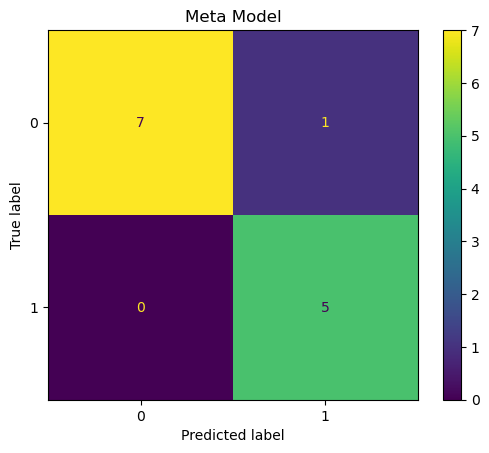

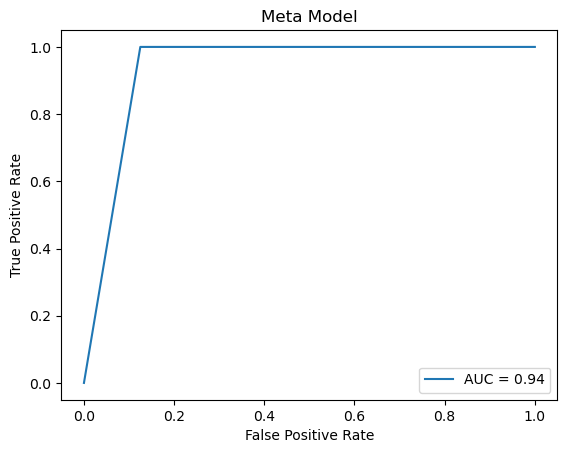

In [18]:
# using validation predictions compute accuarcy of meta-model
accuracy = accuracy_score(y_rna_val, meta_predict_val)
print(f'Validation Accuracy of Meta Model: {accuracy:.2f}')

#confusion matrix
cm = confusion_matrix(y_rna_val, meta_predict_val, labels = None)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = best_model_meth.classes_)
disp.plot()
plt.title('Meta Model')  
plt.show()

# calculate tp, tn, fp, and fn, for later metrics 
tn_mm, fp_mm, fn_mm, tp_mm = confusion_matrix(y_rna_val, meta_predict_val).ravel()

# ROC curve
fpr_mm, tpr_mm, thresholds_mm = roc_curve(y_rna_val, meta_predict_val, pos_label = 1)
roc_auc_mm = auc(fpr_mm, tpr_mm)
display = RocCurveDisplay(fpr = fpr_mm, tpr = tpr_mm, roc_auc = roc_auc_mm)
display.plot()
plt.title('Meta Model')  
plt.show()

# calculate other metrics 
mm_test_accuracy= round(accuracy_score(y_rna_val, meta_predict_val), 2)
mm_specifity= round(tn_mm /(tn_mm + fp_mm), 2)
mm_recall= round(tp_mm /(tp_mm + fn_mm), 2)
mm_precision= round(tp_mm /(tp_mm + fp_mm), 2)
mm_f1score= round(2*((mm_precision * mm_recall) / (mm_precision + mm_recall)), 2)
mm_auc = round(auc(fpr_mm, tpr_mm), 2) 
mm_list= ["Meta Model logistic regression", mm_test_accuracy, mm_specifity, mm_recall, mm_precision, mm_f1score, mm_auc]

In [19]:
# make table with metrics
cols= ["Classifier","Accuracy","Specifity","Recall","Precision","F1-score","AUC"]

# consider a list
list_classifiers = [rna_list, meth_list, mm_list]

In [20]:
# table of metrics for each model
results = pd.DataFrame(list_classifiers, columns=cols)
results

,Classifier,Accuracy,Specifity,Recall,Precision,F1-score,AUC
0,RNA logistic regression,0.62,0.38,1.0,0.50,0.67,0.69
1,Methylation logistic regression,0.77,0.88,0.6,0.75,0.67,0.74
2,Meta Model logistic regression,0.92,0.88,1.0,0.83,0.91,0.94
